# Explicit ODE Schemes

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

## Schemes

### Explicit Euler

In [2]:
def explicit_euler(y0 : np.ndarray, t : float, f, dt : float):
    return y0 + f(y0, t) * dt

### Runge-Kutta 2

In [3]:
def runge_kutta_2(y0 : np.ndarray, t : float, f, dt : float):
    k1 = f(y0, t)
    k2 = f(y0 + k1 * dt, t + dt)
    return y0 + (k1 + k2)/2 * dt

### Runge-Kutta 4

In [4]:
def runge_kutta_4(y0 : np.ndarray, t : float, f, dt : float):
    k1 = f(y0, t)
    k2 = f(y0 + k1/2 * dt, t + dt/2)
    k3 = f(y0 + k2/2 * dt, t + dt/2)
    k4 = f(y0 + k3 * dt, t + dt)
    return y0 + (k1 + 2*k2 + 2*k3 + k4)/6 * dt

### Leapfrog

In [5]:
def leapfrog(y0 : np.ndarray, t : float, f, dt : float):
    
    # split y0 into position and velocity
    r_0 = y0[:2]
    v_0 = y0[2:]

    def f_v(r):
        return f(np.concatenate((r, (0, 0))), t)[2:]

    # take the first leap for the velocity
    v_1_div_2 = v_0 + f_v(r_0) * dt/2
    r_1 = r_0 + v_1_div_2 * dt
    v_1 = v_1_div_2 + f_v(r_1) * dt/2

    return np.concatenate((r_1, v_1))

### Semi-implicit Euler

In [6]:
def semi_implicit_euler(y0 : np.ndarray, t : float, f, dt : float):
    
    # split y0 into position and velocity
    r_0 = y0[:2]
    v_0 = y0[2:]

    # split the function into position and velocity parts
    f_r = lambda v : f(np.concatenate(((0, 0), v)), t)[:2]
    f_v = lambda r : f(np.concatenate((r, (0, 0))), t)[2:]

    # take the leaps
    v_1 = v_0 + f_v(r_0) * dt
    r_1 = r_0 + f_r(v_1) * dt

    return np.concatenate((r_1, v_1))

### Wrapper

The user calls the wrapper function `integrate`, which, in turn, calls the appropriate scheme.

In [7]:
def integrate(y0 : np.ndarray, f, method : str, dt : float, t_end : float):
    """Integrate the ODE y' = f(y, t) up to t_end with timestep dt using the given method."""
    
    t = np.arange(0, t_end, dt)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    
    if method == "explicit_euler":
        integrator = explicit_euler
        
    elif method == "runge_kutta_2":
        integrator = runge_kutta_2

    elif method == "runge_kutta_4":
        integrator = runge_kutta_4

    elif method == "leapfrog":
        integrator = leapfrog

    elif method == "semi_implicit_euler":
        integrator = semi_implicit_euler

    for i in range(1, len(t)):
        y[i] = integrator(y0 = y[i-1], t = t[i], f = f, dt = dt)
    
    return t, y


## Example: Kepler Problem

### Initial conditions and setup

Equations of motion: $\ddot{\vec{r}} = -\frac{G M}{r^3} \vec{r}$

In [8]:
import numpy as np
# inital conditions
# implicit: GM = 1
# star is at rest at the origin

#planet
e = 0.5 # eccentricity
r0 = np.array([1, 0]) # planet's position
v0 = np.array([0, np.sqrt(1+e)]) # planet's velocity

y0 = np.array([r0, v0]).flatten() # the flatten method converts the 2D array into a 1D array

def f(y_vec, t):
    x, y, vx, vy = y_vec
    r_pow_3_div_2 = np.linalg.norm([x, y])**3
    return np.array([vx, vy, - x / r_pow_3_div_2, - y / r_pow_3_div_2])

### Integration

C:\Users\FLOORV~1\AppData\Local\Temp/ipykernel_10040/3945168747.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([vx, vy, - x / r_pow_3_div_2, - y / r_pow_3_div_2])


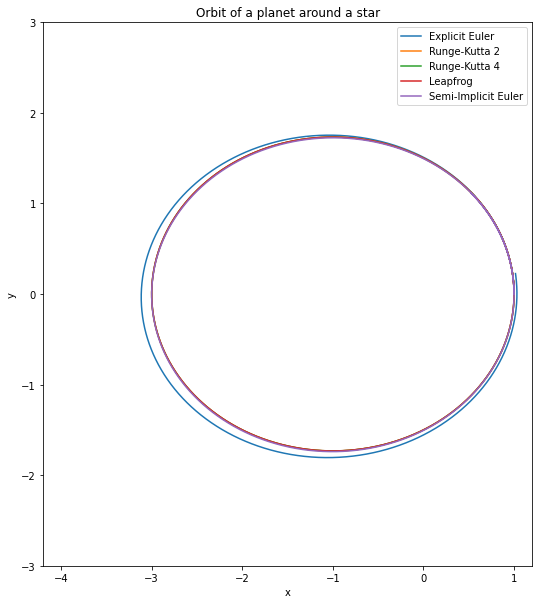

In [9]:
t_orbit = 2*np.pi
dt = t_orbit/1000
t_end = 3*t_orbit

t_ee, y_ee = integrate(y0 = y0, f = f, method = "explicit_euler", dt = dt, t_end = t_end)
t_rk2, y_rk2 = integrate(y0, f, "runge_kutta_2", dt = dt, t_end = t_end)
t_rk4, y_rk4 = integrate(y0, f, "runge_kutta_4", dt = dt, t_end = t_end)
t_leapfrog, y_leapfrog = integrate(y0, f, "leapfrog", dt = dt, t_end = t_end)
t_semi_implicit, y_semi_implicit = integrate(y0, f, "semi_implicit_euler", dt = dt, t_end = t_end)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect("equal")
ax.plot(y_ee[:,0], y_ee[:,1], label = "Explicit Euler")
ax.plot(y_rk2[:,0], y_rk2[:,1], label = "Runge-Kutta 2")
ax.plot(y_rk4[:,0], y_rk4[:,1], label = "Runge-Kutta 4")
ax.plot(y_leapfrog[:,0], y_leapfrog[:,1], label = "Leapfrog")
ax.plot(y_semi_implicit[:,0], y_semi_implicit[:,1], label = "Semi-Implicit Euler")
ax.set_title("Orbit of a planet around a star")
ax.set_xlim(-4.2, 1.2)
ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Rebound example

In [11]:
import rebound
import numpy as np
import matplotlib.pyplot as plt

# Create a simulation
sim = rebound.Simulation()

# Set simulation time
time = 1e3

# Set units
sim.units = ('yr', 'AU', 'Msun')

# Add particles: Sun and Jupiter
sim.add(m=1, hash="Sun")
sim.add(m=1e-3, a=5.5, r=4.676e-4, hash="Jupiter")

# Move to the barycenter frame
sim.move_to_com()

# Choose a valid integrator
sim.integrator = "ias15"  # 'ias15' is a general-purpose, high-accuracy integrator


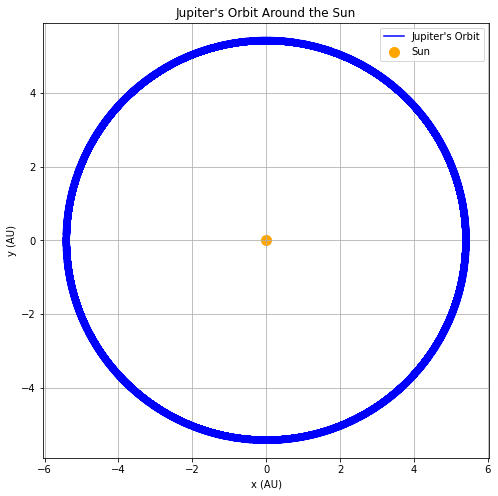

In [12]:
# Set up simulation time and time steps
time = 1e3  # Total time to simulate (years)
N_steps = 1000  # Number of steps for plotting
times = np.linspace(0, time, N_steps)

# Arrays to store positions
x_jupiter = []
y_jupiter = []

# Integrate while collecting data
for t in times:
    sim.integrate(t)
    jupiter = sim.particles[1]
    x_jupiter.append(jupiter.x)
    y_jupiter.append(jupiter.y)

# Plot results
plt.figure(figsize=(8, 8))
plt.plot(x_jupiter, y_jupiter, label="Jupiter's Orbit", color="blue")
plt.scatter(0, 0, color="orange", label="Sun", s=100)  # Sun at the origin
plt.xlabel("x (AU)")
plt.ylabel("y (AU)")
plt.title("Jupiter's Orbit Around the Sun")
plt.axis("equal")
plt.grid()
plt.legend()
plt.show()